In [1]:
# Import Libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Setup
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Display Pandas Outputs
pd.set_option('display.max_columns', 50)

In [2]:
orders = pd.read_csv("../data/orders.csv")
order_products = pd.read_csv("../data/order_products__prior.csv")
products = pd.read_csv("../data/products.csv")
aisles = pd.read_csv("../data/aisles.csv")
departments = pd.read_csv("../data/departments.csv")


In [4]:
print(orders.shape, orders.columns)
print(order_products.shape, order_products.columns)

(3421083, 7) Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order'],
      dtype='object')
(32434489, 4) Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered'], dtype='object')


In [12]:
# Orders per customer
orders_per_user = orders.groupby("user_id")["order_id"].count()
print("Orders per user statistics:")
print(orders_per_user.describe())
print("\n")

# Products per order
products_per_order = order_products.groupby("order_id")["product_id"].count()
print("Products per order statistics:")
print(products_per_order.describe())

Orders per user statistics:
count    206209.000000
mean         16.590367
std          16.654774
min           4.000000
25%           6.000000
50%          10.000000
75%          20.000000
max         100.000000
Name: order_id, dtype: float64


Products per order statistics:
count    3.214874e+06
mean     1.008888e+01
std      7.525398e+00
min      1.000000e+00
25%      5.000000e+00
50%      8.000000e+00
75%      1.400000e+01
max      1.450000e+02
Name: product_id, dtype: float64


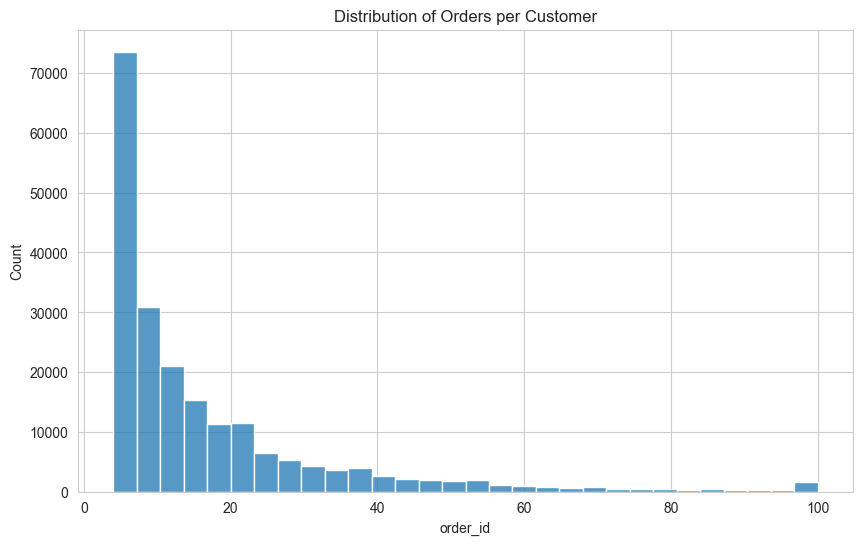

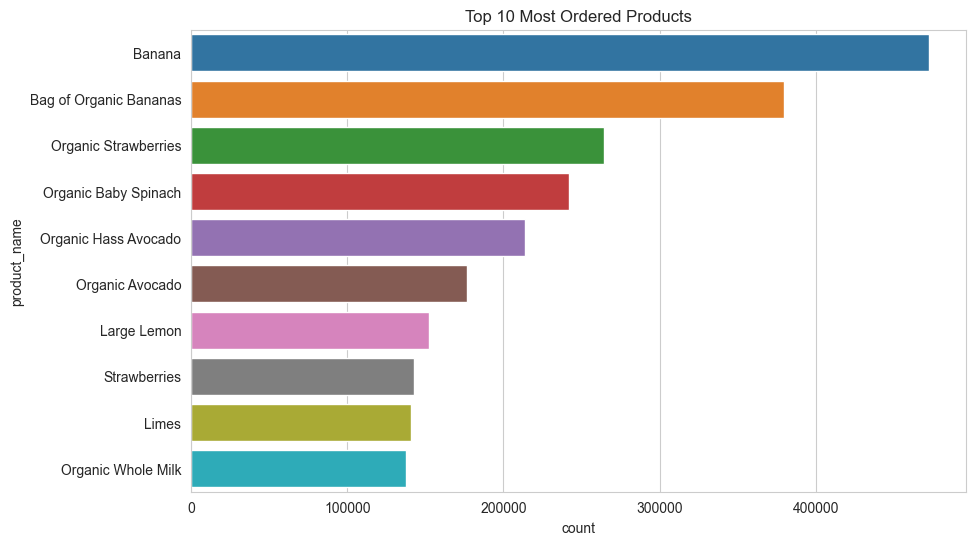

Overall reorder ratio: 0.59


In [15]:
# Orders per customer distribution
sns.histplot(orders_per_user, bins=30, kde=False)
plt.title("Distribution of Orders per Customer")
plt.show()

# Top products
top_products = (
    order_products["product_id"]
    .value_counts()
    .head(10)
    .rename_axis("product_id")
    .reset_index(name="count")
    .merge(products, on="product_id")
)
sns.barplot(data=top_products, x="count", y="product_name")
plt.title("Top 10 Most Ordered Products")
plt.show()

# Reorder ratio
reorder_ratio = order_products["reordered"].mean()
print(f"Overall reorder ratio: {reorder_ratio:.2f}")
